# Credit Risk Modeling 

In this notebook I will be using a dataset on borrower information and loan status to examine factors that contribute to loan risk and probability of default. I will build Logistic Regression, Random Forest, and XGBoost models then compare their accuracy in predicting default outcomes. 

## Summary

Highest Accuracy: XGBoost (~94% accuracy)
- Highest Feature Importance: `person_home_ownership = RENT`

Second Highest Accuracy: Random Forest (~93% accuracy)
- Highest Feature Importance: `percent_loan_income`

Third Highest Accuracy: Logistic Regression (~86% accuracy)
- Highest Feature Importance: `loan_grade`

## Setup

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler

####

os.chdir(r"C:\Users\Brendan\OneDrive - McMaster University\Documents\Professional\Projects\Credit_Risk")
df = pd.read_csv("credit_risk_dataset.csv")
df.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Data Exploration

First we'll look at the overall dimensions of the dataframe

In [98]:
df.shape 

(32581, 12)

So about 32k observations of 12 features. For machine learning applications we need to preprocess numeric vs categorical features differently. Let's check out our numeric data:

In [ ]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


One thing I notice is that there are some probable outliers in the data. Age = 144 years old, employment length = 123 years, income = 6,000,000 are the most eyebrow-raising ones.

For now let's just visualize the distributions of all of the numerical data:

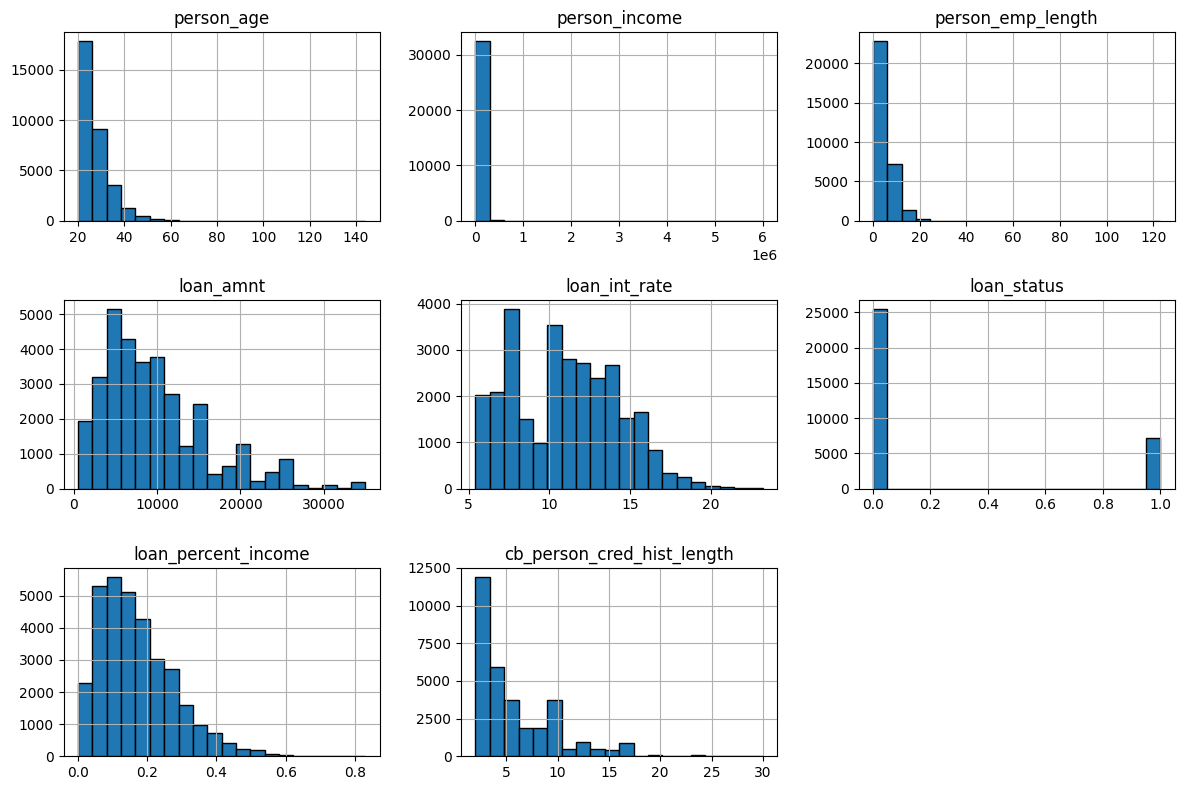

In [100]:
numeric_cols = df.describe().columns

# Some histograms:
df[numeric_cols].hist(figsize=(12,8), bins=20, edgecolor="black") 
plt.tight_layout() 
plt.show() 

We have some strong visual skew of age, income, and employment length. Loan percent income and credit history length are also skewed but seem a bit more natural

Let's make a copy of the dataset to modify, so that we can have df remain unchanged:

In [101]:
dat = df.copy() 

First thing we want to do is to delete the age outliers. We already know we have someone who's 144 years old, let's see if there are any other super old indivs:

In [102]:
age_table = dat.groupby("person_age").size().reset_index(name="Count")
age_table.columns = ["Age", "Count"]
print(age_table)


    Age  Count
0    20     15
1    21   1229
2    22   3633
3    23   3889
4    24   3549
5    25   3037
6    26   2477
7    27   2138
8    28   1854
9    29   1687
10   30   1316
11   31   1142
12   32    964
13   33    856
14   34    709
15   35    620
16   36    548
17   37    478
18   38    373
19   39    302
20   40    271
21   41    241
22   42    188
23   43    164
24   44    141
25   45    108
26   46     94
27   47     94
28   48     75
29   49     49
30   50     52
31   51     39
32   52     36
33   53     30
34   54     24
35   55     20
36   56     15
37   57     15
38   58     19
39   59      5
40   60     15
41   61      9
42   62      7
43   63      3
44   64      7
45   65      9
46   66      9
47   67      1
48   69      5
49   70      7
50   73      3
51   76      1
52   78      1
53   80      1
54   84      1
55   94      1
56  123      2
57  144      3


Another way to do this is to do a pivot table, using the age as an index and counting the number of values in a different column, i.e. loan percent of income. 
<br>
<br>
Note that pivot_table only counts instances where the value for the column is not null, so if we have missing values in the column we're counting, they won't be included in the count and we would get different results than if we used the groupby method above.

In [103]:
dat.pivot_table(index="person_age", values="loan_percent_income", aggfunc="count")

,loan_percent_income
person_age,
20,15
21,1229
22,3633
23,3889
24,3549
25,3037
26,2477
27,2138
28,1854


Okay so we can see that we have actually a handful of high ages, 2 of which are 123 and 2 of which are 144 years old. Let's cut out everyone older than 70 years old:

In [104]:

dat_agefilter = dat[dat["person_age"] <= 70]
dat_agefilter.shape # removed 20 rows

(32568, 12)

Now let's make a table seeing how many people have how many years of employment length. Let's also check their loan status aggregates while we're at it
<br>
<br>
Let's put these in descending order of years of employment, because we remember seeing someone employed for 123 years which we want to check out

In [105]:

dat.pivot_table(index="person_emp_length", columns = "loan_status", values="loan_percent_income", aggfunc="count").reset_index().sort_values(by="person_emp_length", ascending=False)

loan_status,person_emp_length,0,1
35,123.0,1.0,1.0
34,41.0,1.0,NaN
33,38.0,1.0,NaN
32,34.0,NaN,1.0
31,31.0,4.0,NaN
30,30.0,1.0,1.0
29,29.0,NaN,1.0
28,28.0,3.0,NaN
27,27.0,4.0,1.0
26,26.0,5.0,1.0


In fact we have two records of someone with 123 years of employment length, and they weren't filtered out when we filtered out our age outliers. This means the employment length is also an outlier separate from the age
<br>
<br>
Let's remove those employment outliers, say filtering out anyone with more than 40 years employment (because the next set of values was 38 years):

In [106]:
dat_age_empfilter = dat_agefilter[dat_agefilter["person_emp_length"] < 40]
dat_age_empfilter.describe()


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,31671.000000,3.167100e+04,31671.000000,31671.000000,28626.000000,31671.000000,31671.000000,31671.000000
mean,27.717754,6.649231e+04,4.780714,9660.637492,11.040070,0.215497,0.169621,5.804395
std,6.159859,5.277413e+04,4.028718,6334.716643,3.229507,0.411173,0.106275,4.048776
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.936600e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,70.000000,2.039784e+06,38.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Okay so we still have someone making 2 million dollars a year but other than that the numbers look much better. Let's move on to NULL values

In [107]:
dat_age_empfilter.isnull().sum() 

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3045
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

We have lots of null values for the loan interest rate, and none for the other columns

So the fact that we have a bunch of missing rate values is a small problem that will require some imputation. 

We could impute the missing values with the mean or median of the column, as they are pretty close to each other (11.04% mean, 10.99% median as per the `describe()` output above)

Importantly, we will wait until after the train-test split to do the mean imputation! Otherwise we are opening ourselves up to 'data leakage' - using 'global' values of the dataset to inform our model during the training phase. This will overinflate our estimates of accuracy, which would then lead us to be disappointed in our model's performance when it came time to generalize it to new data.

## Train-Test Split

We will perform a standard 80-20 train-test split on the dataset, with loan_status as the target. We will then verify that the relative proportions of defaults and non defaults are comparable between the training and test datasets, to make sure that we are not imbalancing our classes during model evaluation.

In [108]:
# Set up dataframe and target column:
df = dat_age_empfilter.copy()
X = df.drop(columns=["loan_status"])
y = df["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 12345,
    stratify = y # retain the 0.785/0.215 split of the binary target variable
)

# Verify class distribution on target variable in train/test sets
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))  

loan_status
0    0.784496
1    0.215504
Name: proportion, dtype: float64
loan_status
0    0.78453
1    0.21547
Name: proportion, dtype: float64


Now we have our train and test sets, and the target ratio has been held constant

Our next steps are to start preprocessing the data. Recall that we had a bunch of missing values for the loan interest rate and we wanted to mean impute them. We can do that now, because we're working with separate train and test sets so as long as we use the train data characteristics for our preprocessing we will avoid data leakage.

In [109]:
loan_grade_means_train = X_train.join(y_train).groupby('loan_grade', observed=False)['loan_status'].mean()
print(loan_grade_means_train)

loan_grade
A    0.094216
B    0.159956
C    0.199449
D    0.597956
E    0.636364
F    0.693069
G    0.980392
Name: loan_status, dtype: float64


## Mean Imputation of Loan Interest Rates

To mean impute the interest rates, we will first create an imputer object. We will specify it to use `mean` as its technique. We will then fit it to the training data, and apply it to transform both the train and test side of loan interest rate missing values to the training set mean.

In [110]:
# Create the SimpleImputer object, specifying 'mean' as the technique to use:
imputer = SimpleImputer(strategy="mean")

# Fit and transform the loan_int_rate column of the training set:
X_train['loan_int_rate'] = imputer.fit_transform(X_train[['loan_int_rate']]) # fit to the train data mean, then transform accordingly

Now our training data has been preprocessed so that missing values of the loan interest rate are replaced with the mean loan interest rate, specific to the training dataset. 

It's very important that we apply this same imputation to the test dataset, but ALSO use the train dataset mean. This is because, to avoid data leakage, we have to 'view all attributes according to our training data'. There's probably a better way of articulating that. 

In [111]:
X_test['loan_int_rate'] = imputer.transform(X_test[['loan_int_rate']]) # only transform, don't fit

## Examining Categorical Variables

Let's look at our categorical variables now

In [112]:
X_test.head() 

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15540,23,76000,RENT,3.0,VENTURE,B,15000,10.74,0.20,N,4
16441,26,51996,MORTGAGE,2.0,DEBTCONSOLIDATION,E,6500,15.68,0.13,N,3
1313,20,64000,RENT,3.0,VENTURE,D,16000,15.31,0.25,Y,4
2309,25,24996,RENT,8.0,VENTURE,C,2500,12.98,0.10,N,4
4638,24,42000,MORTGAGE,3.0,EDUCATION,A,8675,7.51,0.21,N,4


Looking at the dataframe it looks like our categorical variables are `person_home_ownership`, `loan_intent`, `loan_grade`, and `cb_person_default_on_file`

In [113]:
# Let's look at home ownership first. Let's see how many people fall into each category:
X_train["person_home_ownership"].value_counts()

# Another way of doing it:
X_train.groupby('person_home_ownership').count()['loan_intent']

person_home_ownership
MORTGAGE    10535
OTHER          80
OWN          1930
RENT        12791
Name: loan_intent, dtype: int64

Pretty balanced between people with active mortgages and renters. Relatively few people outright own their home (but they would probably be good to lend to), and there are a handful of 'other' cases

Let's do the same thing for `loan_intent`, i.e. what the borrower intends to use the loan for:

In [114]:
X_train["loan_intent"].value_counts()

loan_intent
EDUCATION            5003
MEDICAL              4650
VENTURE              4449
PERSONAL             4335
DEBTCONSOLIDATION    4095
HOMEIMPROVEMENT      2804
Name: count, dtype: int64

Things are pretty balanced there. Now let's look at loan grades, i.e. the pre-judgment from the lender on whether this is a high quality loan (likely to be mutually beneficial, favourable lending conditions) or low quality (unfavourable conditions)

In [115]:
X_train["loan_grade"].value_counts()

loan_grade
A    8247
B    8171
C    5079
D    2838
E     748
F     202
G      51
Name: count, dtype: int64

So most loans are graded in the A or B range, with fewer cases in E/F/G. We would predict to see a higher default rate in the lower graded loans

Because this is a categorical variable we'll have to transform (i.e. encode) it into numerical format - we can ordinally encode it to ensure that the categories retaintheir ordinal relationship

Alternatively we can use target encoding, where we replace the category value with the mean default rate of that category. 

Let's visualize the loan interest rate by loan grade. We'll want to make sure that loan_grade is ordered.

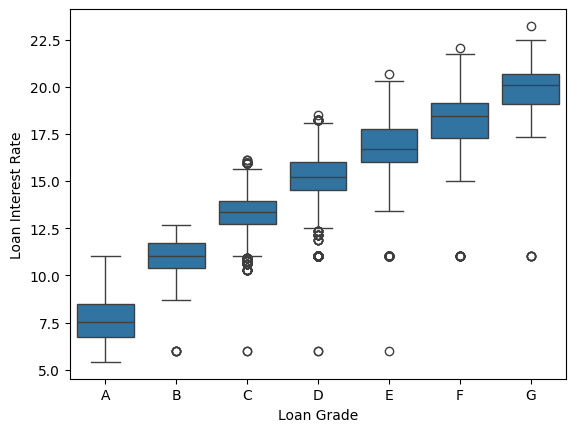

In [116]:
X_train["loan_grade"] = pd.Categorical(X_train["loan_grade"], categories=["A", "B", "C", "D", "E", "F", "G"], ordered=True)
sns.boxplot(x="loan_grade", y="loan_int_rate", data=X_train)
plt.ylabel("Loan Interest Rate")
plt.xlabel("Loan Grade")
plt.show()

Wow, that's quite the relationship. Pretty positive, linear relationship where loans graded worse have higher interest rates. Those might be hard to pay off! I'd bet that worse graded loans have higher default rates, we'll get there in due time. This makes me think we might have been better off using a slightly more sophisticated method to impute the missing interest rate values, and used the loan-grade-specific mean interest rate as opposed to the overall mean interest rate. If we have poor model performance we'll see if we need to tweak that.



Let's also visualize the loan amount as a function of loan grade:

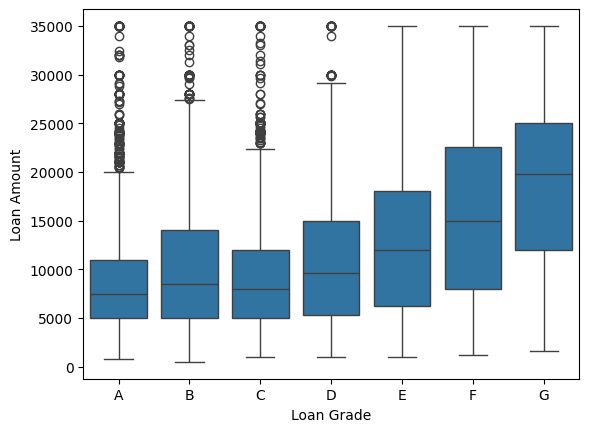

In [117]:
sns.boxplot(x="loan_grade", y="loan_amnt", data=X_train)
plt.ylabel("Loan Amount")
plt.xlabel("Loan Grade")
plt.show()


Less pronounced relationship but we see a higher concentration of modest loan amounts in the first three or four grades

Back to my earlier prediction though, I want to see the default rate binned by loan grade. We've already split the loan status out of our training dataset though, as it is our target, so we'll have to briefly join them back together again

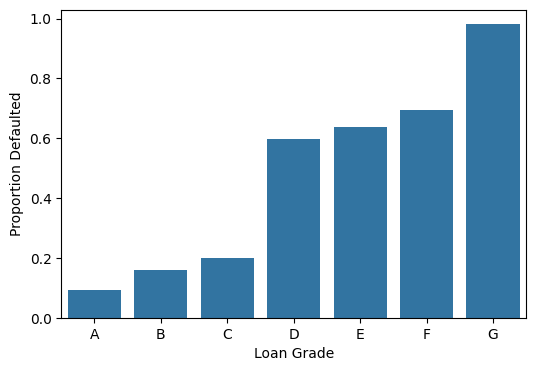

In [118]:
grade_default_rates = X_train.join(y_train).groupby('loan_grade', observed=False)['loan_status'].mean()
plt.figure(figsize=(6,4))
sns.barplot(x=grade_default_rates.index, y=grade_default_rates.values)
plt.xlabel("Loan Grade")
plt.ylabel("Proportion Defaulted")
plt.show()

Wow, that's a pretty staggering result. Almost 100% of loans graded as 'G' go into default! 

Let's visualize the relationship between default probability and interest rate using Logistic Regression. We would predict to see higher default probability as a function of interest rate, as the loans become harder and harder to pay off.

We are using the old, pre-mean-imputed dataframe, so there will be lots of NAs in the `loan_int_rate` column that will cause the model to break. So we will build the model in a way that just removes those NAs for now.

Optimization terminated successfully.
         Current function value: 0.466884
         Iterations 6


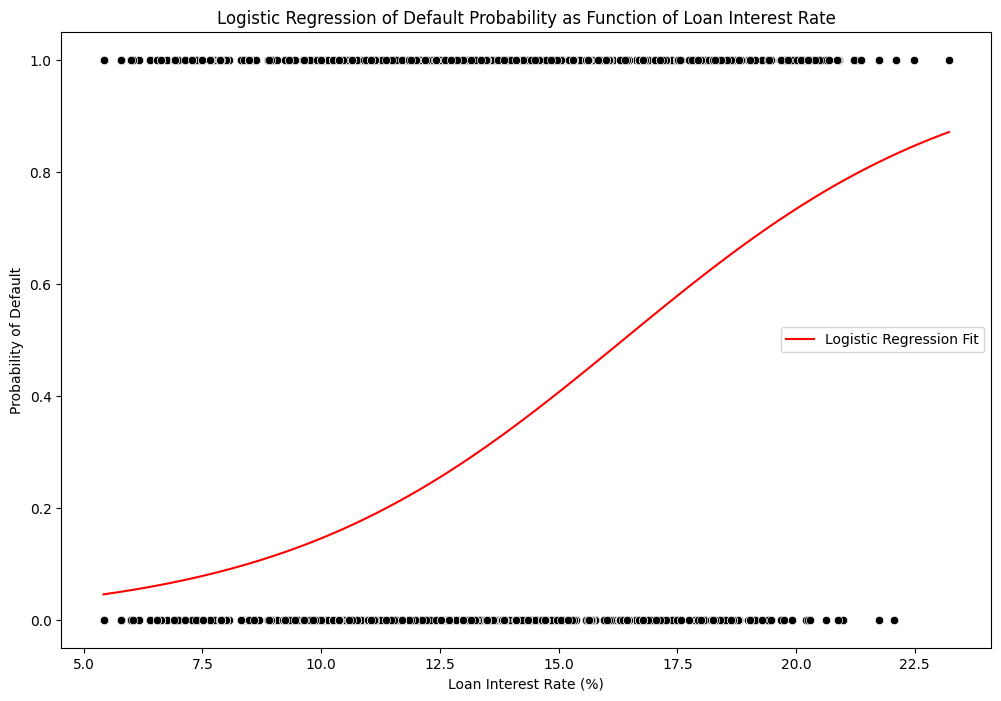

In [119]:
# Drop rows with NaN values in either loan_int_rate and loan_status columns
df_clean = X_train.join(y_train).dropna(subset=['loan_int_rate', 'loan_status'])

# Fit the logistic regression model itself
X = sm.add_constant(df_clean["loan_int_rate"])
y = df_clean["loan_status"]
logit_model = sm.Logit(y, X).fit() 

# Generate predictions using the model and a synthetic vector of values within the range of interest rates
interest_range = np.linspace(df_clean['loan_int_rate'].min(), df_clean['loan_int_rate'].max(), 100)
X_pred = sm.add_constant(interest_range)
y_pred = logit_model.predict(X_pred)

# Plot the data points and the fitted curve
plt.figure(figsize=(12,8))
sns.scatterplot(x=df_clean['loan_int_rate'], y = df_clean['loan_status'], color='black')
plt.plot(interest_range, y_pred, color='red', label='Logistic Regression Fit')

# Formatting
plt.xlabel('Loan Interest Rate (%)')
plt.ylabel('Probability of Default')
plt.title('Logistic Regression of Default Probability as Function of Loan Interest Rate')
plt.legend()
plt.show()


So we see a positive sigmoidal relationship between interest rates and default probability. This is what we would expect, as higher interest rates make the loans more expensive and harder to pay off. Let's connect this back to our loan grades, and just take a peek at the numerical default rates of each grade:

In [120]:
df_clean.groupby("loan_grade", observed=False)["loan_status"].mean()

loan_grade
A    0.094216
B    0.159956
C    0.199449
D    0.597956
E    0.636364
F    0.693069
G    0.980392
Name: loan_status, dtype: float64

Our suspicion is true, the lower in the loan grade you go the higher the default rate. Notice that class G has a near 100% default rate! We could probably improve lending practices by retaining the criteria that grade a loan out as G, but then decline to provide those loans. If our goal is to minimize default rate, it would be best to promote loans in the A/B/C range, maybe do a handful of C/D/E loans, try to avoid E/F, and never give out G. But lenders aren't necessarily prioritizing minimization of deault, but rather *maximizing profit*. It's possible that there's a sweet spot between interest rates where you're receiving most of your payments, a few loans may go into default but overall you are profiting well from those investments.

Because the different loan grades have a pretty meaningful mapping onto default rate, we should include them in our analysis. Later on we'll target encode them to the average probability of each grade defaulting. 

Another categorical variable we haven't really looked at yet is loan intent, or what the money will actually be used for. Once again we are using the global dataset to look at this, because we've decoupled the loan status from the rest of the data in the training set already:

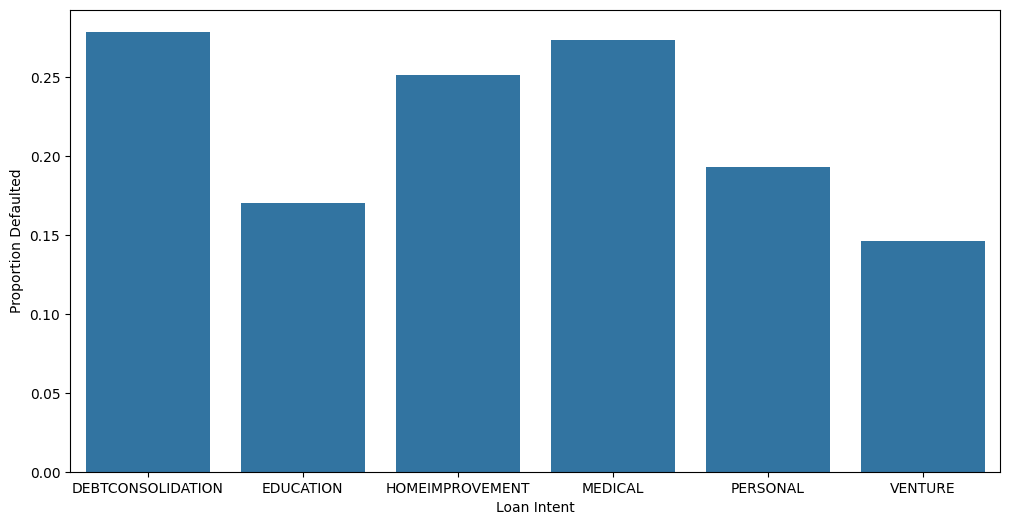

In [121]:
intent_default_rates = df_clean.groupby('loan_intent')['loan_status'].mean()
plt.figure(figsize=(12,6))
sns.barplot(x=intent_default_rates.index, y=intent_default_rates.values)
plt.xlabel("Loan Intent")
plt.ylabel("Proportion Defaulted")
plt.show()

The probability distribution is pretty uniform, with possibly a slight bump for debt consolidation. Makes sense, if someone had enough debt to need a consolidation it's likely that their financial situation or habits aren't quite the best and would be more likely to default on the consolidation loan. 

Interestingly, the highest default proportion for consolidation is still only ~0.3. So the nature of the loan is far less prescriptive in terms of default probability than the grade or interest rate, it would seem.

Let's do this type of figure again for the home ownership category - someone who outright owns their home and doesn't have a mortgage or rent to pay should in theory have more free cash flow (with the caveat that they may be retired and not have as much annual income), and might be able to service a loan better. My guess is we see lower default rates for owners compared to renters.

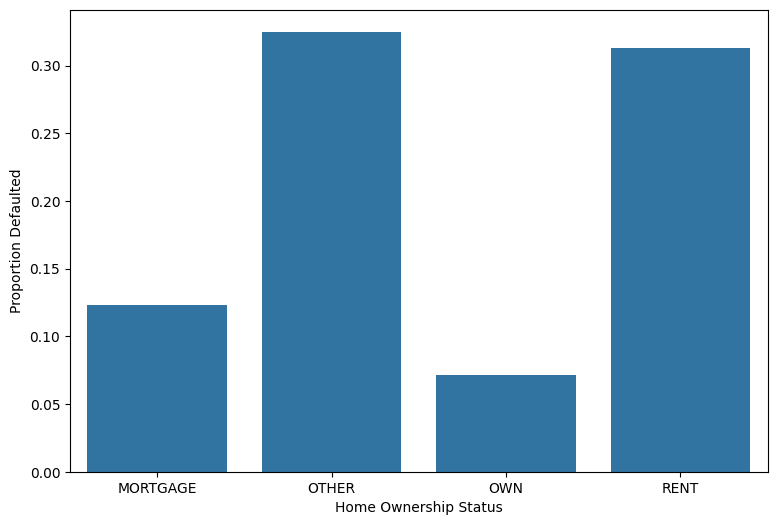

In [122]:
home_default_rates = df_clean.groupby('person_home_ownership')['loan_status'].mean()
plt.figure(figsize=(9,6))
sns.barplot(x=home_default_rates.index, y=home_default_rates.values)
plt.xlabel("Home Ownership Status")
plt.ylabel("Proportion Defaulted")
plt.show()

This matches our expectations for home ownership and suggests that people who outright own a home have an easier time making loan payments.

Interestingly, we also see that people with an active mortgage are pretty low on the default rate, perhaps because they have already demonstrated to a lender that they can manage the finances of a loan.

Lastly, we see that renters and 'others' have higher default rates, likely due to less available cashflow. I'm tempted to collapse 'other' into 'rent' for the purposes of this analysis, but I'll leave it as we want to make as few manipulations to the data as possible

Let's do this type of figure one last time for the 'default on record' feature- someone who has defaulted before might be more likely to default again. One could conceive the opposite effect though. If someone has defaulted already on a loan, it may have taken them a ton of work to improve their financial standing enough to take on another loan. That improvement in standing may lead those individuals to then be *less* likely to default compared to the average population who has not defaulted before. This effect may depend on the strictness of the lending agency that they're getting their post-default loan from.

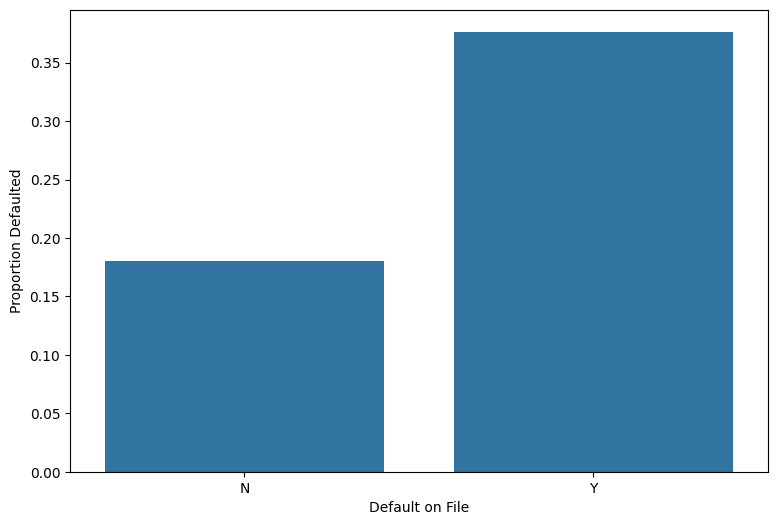

In [123]:
home_default_rates = df_clean.groupby('cb_person_default_on_file')['loan_status'].mean()
plt.figure(figsize=(9,6))
sns.barplot(x=home_default_rates.index, y=home_default_rates.values)
plt.xlabel("Default on File")
plt.ylabel("Proportion Defaulted")
plt.show()

People who have defaulted before are likely to default again. The 'improved financial standing' hypothesis may have been a bit far-fetched but was a fun thought exercise.

## Transforming Categorical Variables

So for our categorical variable transformation we will transform the following:
- person_home_ownership: one-hot encoding
- loan_intent: one-hot encoding
- person_default_on_file: binary encoding
- loan_grade: target encoding

### One hot encoding for home ownership and loan intent

We will initialize the encoder, then apply it to our home ownership and loan intent columns for both the train and test data:

In [124]:


# Import and set up the encoder
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


# Fit and transform the two columns for OHE:
X_train = X_train.reset_index(drop=True) # reset the index to make sure rows line up properly
X_test = X_test.reset_index(drop=True)
# if we're doing that for the train we also need to do it for the test
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
encoded_vars_train = OHE.fit_transform(X_train[['loan_intent', 'person_home_ownership']])
encoded_vars_test = OHE.fit_transform(X_test[['loan_intent', 'person_home_ownership']])


In [125]:
# Convert the encoded variables to a dataframe
encoded_df_train = pd.DataFrame(encoded_vars_train, columns=OHE.get_feature_names_out(['loan_intent', 'person_home_ownership'])).reset_index(drop=True) # reset index to make sure rows line up properly
encoded_df_test = pd.DataFrame(encoded_vars_test, columns=OHE.get_feature_names_out(['loan_intent', 'person_home_ownership'])).reset_index(drop=True)
encoded_df_train.head()

,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Now we need to insert these encoded columns back into our train and test dataframes:

In [126]:
X_train = X_train.drop(columns=['loan_intent', 'person_home_ownership'])
X_test = X_test.drop(columns=['loan_intent', 'person_home_ownership'])

# Concatenate the new encoded columns with the rest of the dataset
X_train = pd.concat([X_train, encoded_df_train], axis=1)
X_test = pd.concat([X_test, encoded_df_test], axis=1)
X_train.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT
0,22,39000,5.0,D,9600,16.77,0.25,Y,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,26,18000,0.0,B,1500,11.36,0.08,N,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,36,44000,9.0,D,9400,13.30,0.21,N,15,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,41,50000,0.0,C,7000,12.87,0.14,Y,12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,30,40000,8.0,A,2500,5.79,0.06,N,10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Binary Encoding of Default History

Time to binary encode the default on file:

In [127]:
X_train['cb_person_default_on_file'] = X_train['cb_person_default_on_file'].map({'Y':1, 'N':0}) # Can also use 'replace()' in the place of map() and keep everything else the exact same and would work the same way
X_test['cb_person_default_on_file'] = X_test['cb_person_default_on_file'].map({'Y':1, 'N':0})

## Scaling Numerical Features

Now we need to standardize our numerical features. We'll create a separate dataframe containing just our numerical features, then we'll standardize both the training and test sets using the descriptive statistics of the training set

In [128]:
# Extract numeric features
scaling_data_train = X_train[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']]
scaling_data_test = X_test[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']]

In [129]:
# Set up the scaler
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(scaling_data_train), columns=scaling_data_train.columns)
test_scaled = pd.DataFrame(scaler.transform(scaling_data_test), columns=scaling_data_test.columns)
train_scaled.describe() # Means are all zero, standard deviations are all 1 (or, at least, approximately 0 and 1)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,2.533600e+04,2.533600e+04,2.533600e+04,2.533600e+04,2.533600e+04,2.533600e+04,2.533600e+04
mean,-1.828520e-16,-4.963927e-17,4.823703e-17,7.936675e-17,2.559087e-16,1.646229e-16,6.338122e-17
std,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00
min,-1.245996e+00,-1.187335e+00,-1.188664e+00,-1.445811e+00,-1.835523e+00,-1.597538e+00,-9.353393e-01
25%,-7.611391e-01,-5.183238e-01,-6.912698e-01,-7.378254e-01,-8.340638e-01,-7.512088e-01,-6.890751e-01
50%,-2.762820e-01,-2.000195e-01,-1.938751e-01,-2.658350e-01,0.000000e+00,-1.869894e-01,-4.428109e-01
75%,3.701941e-01,2.574238e-01,5.522168e-01,4.421505e-01,6.730177e-01,5.653032e-01,5.422458e-01
max,6.834955e+00,3.761118e+01,8.261834e+00,3.982078e+00,3.970982e+00,6.207498e+00,5.960058e+00


In [130]:
# Now we have our numerically scaled data, we need to update the dataframe with encoded values so that we have a dataframe with encoded and scaled data:
# Make a copy of the dataframe to update, with a new name that will be relevant:
X_train_prepped = X_train.copy()
X_test_prepped = X_test.copy()

# it doesn't like that we're putting float data into integer columns, so we'll have to convert the integer columns to float first
X_train_prepped.select_dtypes(include='int').columns
X_test_prepped.select_dtypes(include='int').columns

# Convert age, income, loan amount, and credit history length to float
int_to_float = ['person_age', 'person_income', 'loan_amnt', 'cb_person_cred_hist_length']
X_train_prepped[int_to_float] = X_train_prepped[int_to_float].astype(float)
X_test_prepped[int_to_float] = X_test_prepped[int_to_float].astype(float)




Now we can update our values by joining the scaled features into the non-scaled numeric columns of the X data. `Update()` will find columns with matching names and replace the values

In [131]:
X_train_prepped.update(train_scaled)
X_test_prepped.update(test_scaled)

Okay great, the last thing we need to do is to process our loan grade. We are going to target-encode, meaning that we'll calculate the proportion of each loan grade that defaulted and then map that as a float value for each loan grade. We have to be careful to only use the training set to compute the averages, and then apply those averages to both the train and test set to prevent data leakage

In [132]:
# Compute mean default rates from training set
# First need to join the target variable back to the training set for a hot sec. Then can compute the mean default rates for each loan grade
loan_grade_means = X_train.join(y_train).groupby('loan_grade', observed=False)['loan_status'].mean()
print(loan_grade_means)


loan_grade
A    0.094216
B    0.159956
C    0.199449
D    0.597956
E    0.636364
F    0.693069
G    0.980392
Name: loan_status, dtype: float64


In [133]:
# Map the mean default rates to the loan grade column
X_train_prepped['loan_grade_encoded'] = X_train_prepped['loan_grade'].map(loan_grade_means).astype(float)
X_train_prepped.drop(columns=['loan_grade'], inplace=True)

# repeat for test
X_test_prepped['loan_grade_encoded'] = X_test_prepped['loan_grade'].map(loan_grade_means).astype(float)
X_test_prepped.drop(columns=['loan_grade'], inplace=True)

X_train_prepped.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_grade_encoded
0,-0.922758,-0.524042,0.054822,-0.014107,1.866939,0.753376,1,-0.935339,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.597956
1,-0.276282,-0.924305,-1.188664,-1.288481,0.102153,-0.845245,0,-0.935339,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.159956
2,1.339908,-0.428741,1.049611,-0.045573,0.734997,0.377230,0,2.266095,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.597956
3,2.148003,-0.314380,-1.188664,-0.423165,0.594728,-0.281026,1,1.527303,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.199449
4,0.370194,-0.504982,0.800914,-1.131151,-1.714826,-1.033319,0,1.034774,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.094216


Okay that all looks good! Modeling time.

# Model Fitting

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score


### Model Evaluation function

Let's write a quick function to standardize how we evaluate each model

In [135]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

## Logistic Regression

Time to fit our first model, we'll start with logistic regression:

In [136]:
# Initializing and fitting the model, and making predictions:
logreg = LogisticRegression(max_iter=1000, random_state=12345)
logreg.fit(X_train_prepped, y_train)
y_pred_logreg = logreg.predict(X_test_prepped)

Now let's evaluate the model:

In [137]:
evaluate_model(y_test, y_pred_logreg, "Logistic Regression")


Logistic Regression Evaluation:
Accuracy: 0.8653512233622731
Confusion Matrix:
[[4717  253]
 [ 600  765]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4970
           1       0.75      0.56      0.64      1365

    accuracy                           0.87      6335
   macro avg       0.82      0.75      0.78      6335
weighted avg       0.86      0.87      0.86      6335



Not bad, let's see how the other models do. Also, this is a super barebones fit so we can tweak things from here to improve our accuracy


## Random Forest

Next we'll fit a Random Forest model:

In [138]:
# Initialize the model, fit the model, make predictions
rf = RandomForestClassifier(n_estimators=100, random_state=12345)
rf.fit(X_train_prepped, y_train)
y_pred_rf = rf.predict(X_test_prepped)


Evaluation time:

In [139]:
evaluate_model(y_test, y_pred_rf, "Random Forest")


Random Forest Evaluation:
Accuracy: 0.9330702446724546
Confusion Matrix:
[[4941   29]
 [ 395  970]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4970
           1       0.97      0.71      0.82      1365

    accuracy                           0.93      6335
   macro avg       0.95      0.85      0.89      6335
weighted avg       0.94      0.93      0.93      6335



So far Random Forest beats Logistic Regression. Let's see if we can beat this with XGBoost. Sometimes boosting methods can overfit which can hurt your prediction accuracy, will be interesting to see whether that happens here.

## XGBoost

Our last model fit will be XGBoost, a Gradient Boosting method.

In [140]:
# Initialize and fit the model, then make predictions
xgb_model = XGBClassifier(random_state=12345)
xgb_model.fit(X_train_prepped, y_train)
y_pred_xgb = xgb_model.predict(X_test_prepped)

That took less time to fit than the random forest which is interesting. Let's evaluate it:

In [141]:
evaluate_model(y_test, y_pred_xgb, "XGBoost")


XGBoost Evaluation:
Accuracy: 0.9338595106550908
Confusion Matrix:
[[4918   52]
 [ 367  998]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4970
           1       0.95      0.73      0.83      1365

    accuracy                           0.93      6335
   macro avg       0.94      0.86      0.89      6335
weighted avg       0.93      0.93      0.93      6335



So the XGBoost did ever so slightly better than the Random Forest. 

## Feature Importance

It would be interesting to visualize the feature importance for each model and compare what they honed in on:

In [142]:
# Logistic Regression
logreg_importance = np.abs(logreg.coef_[0])

# Random Forest
rf_importance = rf.feature_importances_

# XGBoost
xgb_importance = xgb_model.feature_importances_

# Create dataframe from these:
importance_df = pd.DataFrame({
    'Feature': X_train_prepped.columns,
    'Logistic Regression': logreg_importance,
    'Random Forest': rf_importance,
    'XGBoost': xgb_importance
})

# Sort by importance (mean of all models):
importance_df = importance_df.set_index('Feature')
importance_df = importance_df.sort_values(by=['Logistic Regression', 'Random Forest', 'XGBoost'], ascending=False)

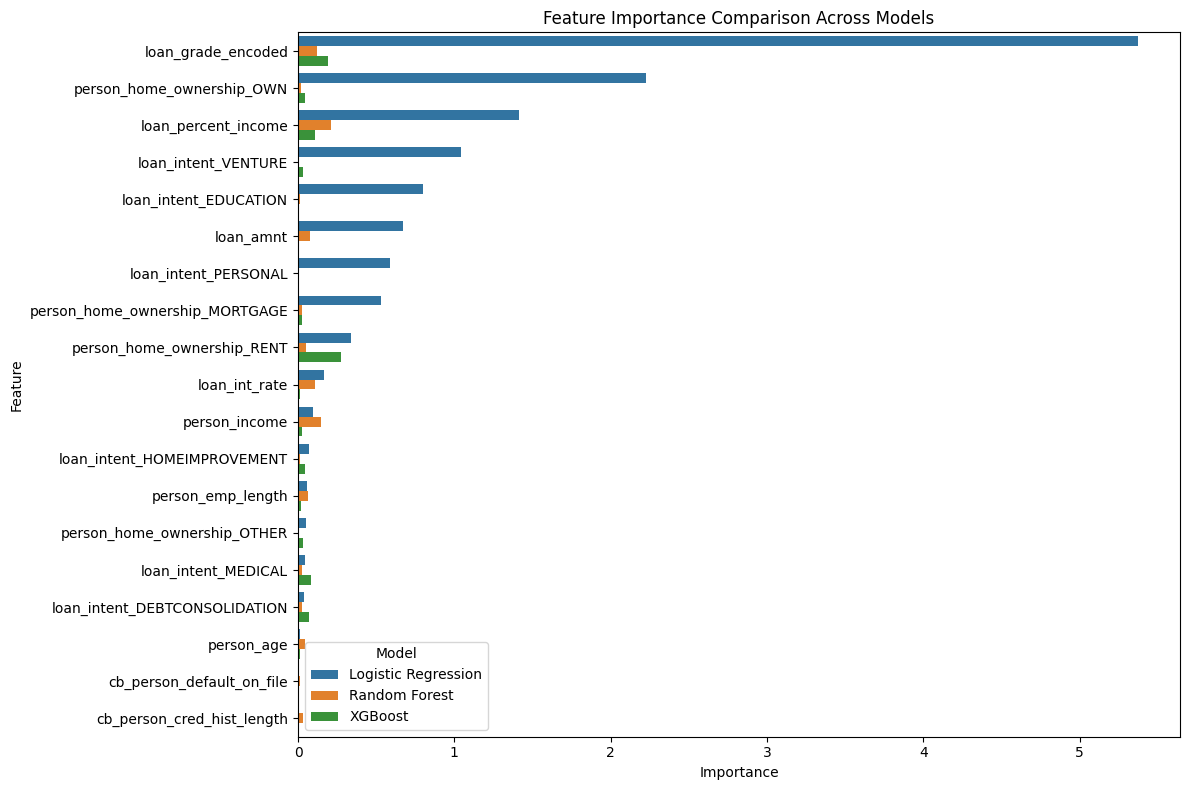

In [143]:
# Plotting with Seaborn
plt.figure(figsize=(12,8))

# Melt dataframe for easier plotting
importance_melt = importance_df.reset_index().melt(id_vars='Feature', var_name='Model', value_name='Importance')

# Create barplot
sns.barplot(x='Importance', y='Feature', hue='Model', data=importance_melt, dodge=True)

# Customize the plot
plt.title('Feature Importance Comparison Across Models')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Show the plot
plt.tight_layout()
plt.show()

One thing we notice right off the bat is that the feature importance values for logistic regression are *much* higher than the two tree-based methods. This is because feature importance for regression-based models just maps onto the coefficient estimates given to each feature, whereas feature importance in tree-based models is calculated in a completely different way. If we wanted to have a more objective comparison across all three models, we would want to standardize the importances within each model type

Let's see what that would look like:

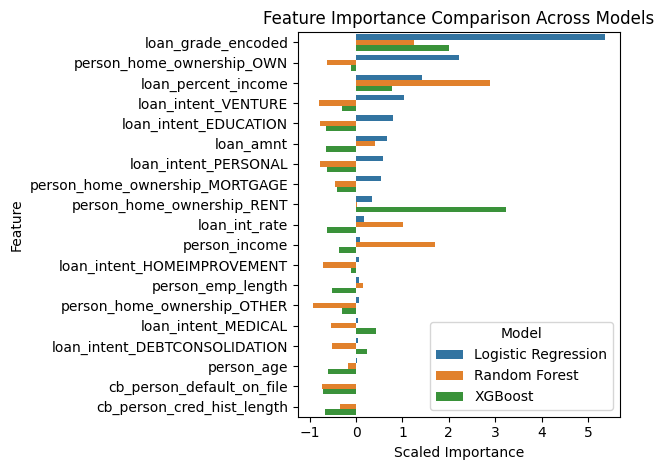

In [144]:
# scale each model's importance values independently, then melt to long format
scaler = StandardScaler()
nums = importance_df.columns[1:]
importance_scaled = importance_df.copy()
importance_scaled[nums] = scaler.fit_transform(importance_df[nums])
imp_scaled_melt = importance_scaled.reset_index().melt(id_vars='Feature', var_name='Model', value_name='Importance')

# Create same barplot as before but with new scaled dataframe
sns.barplot(x='Importance', y='Feature', hue='Model', data=imp_scaled_melt, dodge=True)
plt.title('Feature Importance Comparison Across Models')
plt.xlabel('Scaled Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

This plot is much more legible now that the importances are scaled. We still see that the target-encoded loan grade is very influential, especially in the case of Logistic Regression. This is likely attributable to some of the underlying relationships we visualized early on in this notebook, namely that worse loan grades have very high default rates, and worse loan grades have higher interest rates, and that higher interest rates are associated with a higher probability of default according to our simple logistic regression curve we plotted. 

The logistic regression model is more fixated on single variables 'at a time', in the sense that I didn't tell it to look for interactions, whereas the tree based methods are 'spreading' their importance across the potential interactions between variables as well. So if we were to plot the distribution of each model's importances, or plot the variances between feature importances, we would find that the variance is much higher for logistic regression while the tree based methods have much more uniform sets of importances. 

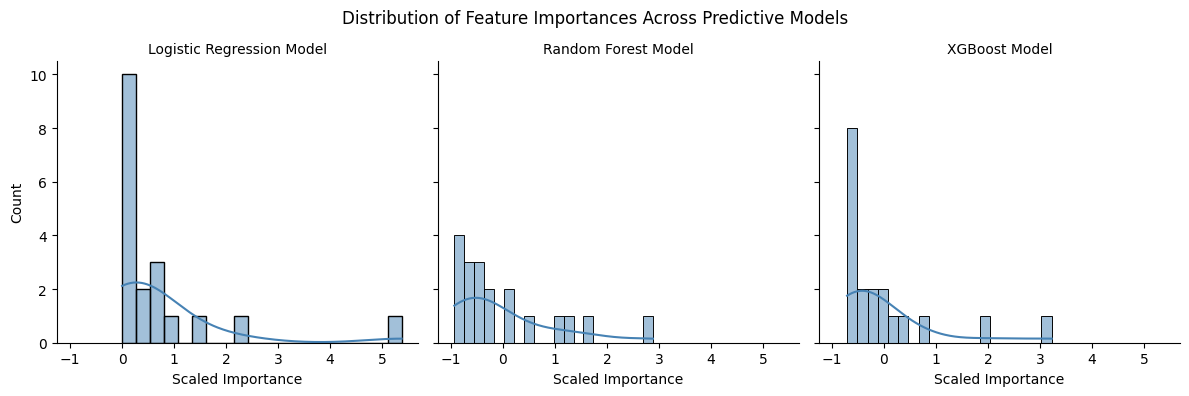

In [145]:
p = sns.FacetGrid(imp_scaled_melt, col="Model", col_wrap=3, sharex=True, sharey=True, height=4)
p.map(sns.histplot, "Importance", kde=True, bins=20, color='steelblue', edgecolor='black')
p.set_axis_labels("Scaled Importance", "Count")
p.set_titles(col_template="{col_name} Model")
plt.suptitle("Distribution of Feature Importances Across Predictive Models")
plt.subplots_adjust(top=0.85)


# Summary

In this notebook we explored a dataset on credit defaults, and implemented a few different machine learning techniques to predict loan defaults. Our most accurate model was XGBoost with an accuracy of roughly 94%, placing highest importance on whether an individual was renting their home or apartment. The second-most accurate model was Random Forest with a roughly 93% accuracy, placing highest importance on the percent of the borrower's income the loan represented. Our third-place model was Logistic Regression at roughly 86%, placing highest importance on what grade the loan was assigned when it was offered.